In [1]:
#Import Libraries
import sys
sys.path.insert(0, "/Users/wandawang/anaconda/lib/python3.6/site-packages")
import os
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from __future__ import division
from scipy import stats
import seaborn as sns
os.chdir('/Users/wandawang/Desktop/takehome')

In [2]:
#Read in the datasets
train = pd.read_table('training.tsv', header=None)
test = pd.read_table('test.tsv', header=None)

In [3]:
#Rename columns
train = train.rename(index=str, columns={0: 'user_id', 1: 'date', 2: 'activity'})
test = test.rename(index=str, columns={0: 'user_id', 1: 'date', 2: 'activity'})

In [4]:
#Exploratory Data analysis
train.head(5)
#There are Multiple activity lines per user_id

,user_id,date,activity
0,00002acbe042d69,2013-07-11,EmailOpen
1,00002acbe042d69,2013-07-11,FormSubmit
2,00002acbe042d69,2013-07-15,EmailOpen
3,00002acbe042d69,2013-07-17,EmailOpen
4,00002acbe042d69,2013-07-18,EmailOpen


In [5]:
#convert date to datetime
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [6]:
#Overview of Training set
df = train
train.describe()

,user_id,date,activity
count,4918677,4918677,4918677
unique,341568,671,7
top,2cd311cc3ef2d0c,2014-06-18 00:00:00,EmailOpen
freq,2718,50184,3191732
first,NaN,2013-07-01 00:00:00,NaN
last,NaN,2015-05-02 00:00:00,NaN


In [7]:
#The most active user only had 2 Purchase events
train[train['user_id']=='2cd311cc3ef2d0c'].activity.value_counts()

EmailOpen            630
PageView             596
WebVisit             596
EmailClickthrough    463
FormSubmit           430
Purchase               2
CustomerSupport        1
Name: activity, dtype: int64

In [8]:
#4918677 total activity instances, 341568 unique user_id's, 671 days, 7 activities
#4918677/341568 = 14.4 average activites per user_id
#user_id == 2cd311cc3ef2d0c was most active, having 2718 activities
#2014-06-18 was the most popular date for an activity to occur
#Date Range: 2013-07-01 to 2015-05-02
#EmailOpen was the most common activity

In [9]:
test.describe() 

,user_id,date,activity
count,797759,797759,797759
unique,132810,92,5
top,2cd311cc3ef2d0c,2015-06-23 00:00:00,EmailOpen
freq,355,45919,550886
first,NaN,2015-05-01 00:00:00,NaN
last,NaN,2015-07-31 00:00:00,NaN


In [10]:
test.activity.value_counts()

EmailOpen            550886
WebVisit              88595
PageView              87149
EmailClickthrough     42364
FormSubmit            28765
Name: activity, dtype: int64

In [11]:
#CustomerSupport is missing from test set
#CustomerSupport always occurs efter a Purchase Event in Train Set
#Throw out Variable CustomerSupport

In [12]:
train[train['activity']=='CustomerSupport'].head(1)

,user_id,date,activity
41,0000ecf58c94668,2014-07-04,CustomerSupport


In [13]:
train[40:42]

,user_id,date,activity
40,0000ecf58c94668,2014-07-03,Purchase
41,0000ecf58c94668,2014-07-04,CustomerSupport


In [14]:
#What are the date ranges?
print(train.date.min(),train.date.max())
print(test.date.min(),test.date.max())

2013-07-01 00:00:00 2015-05-02 00:00:00
2015-05-01 00:00:00 2015-07-31 00:00:00


In [15]:
#How common is each activity? Around 65% of all activities are EmailOpen
train.activity.value_counts()/len(train)*100

EmailOpen            64.890051
Purchase              8.031245
WebVisit              7.807486
PageView              7.771663
EmailClickthrough     5.805789
FormSubmit            3.579560
CustomerSupport       2.114207
Name: activity, dtype: float64

In [16]:
#Group dataset by user_id, date, dummify Activities into binary 0,1
#Note: date is consolidated into single line, so has less rows than original train set. 
train['placeholder'] = 1
pid = pd.crosstab([train.user_id, train.date],columns = train['activity'],aggfunc=np.sum,values=train.placeholder)
pid.reset_index(inplace=True)
pid = pid.fillna(0)

In [17]:
test['placeholder'] = 1
tid = pd.crosstab([test.user_id, test.date],columns = test['activity'],aggfunc=np.sum,values=test.placeholder)
tid.reset_index(inplace=True)
tid = tid.fillna(0)

In [18]:
pid.shape

(3963068, 9)

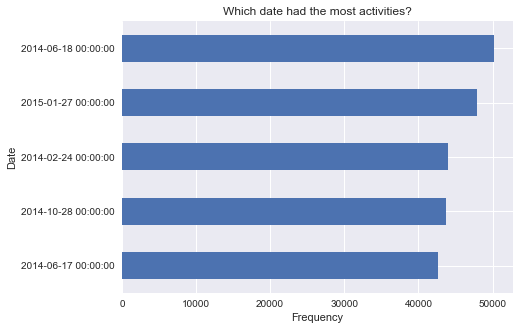

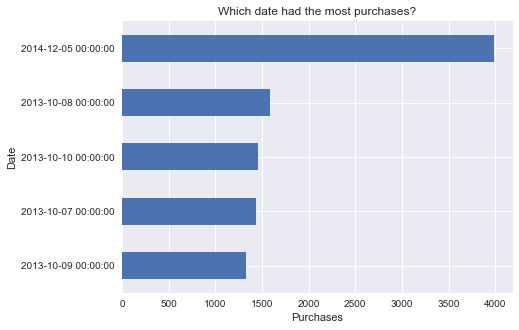

In [19]:
#No. of Campaigns per Week: Which weeks had the most activities?
Num_ = train.groupby('date')['activity'].count().nlargest(5)
plt.figure(figsize=(7,5))
Num_.sort_values().plot(kind='barh') #top 5 #cutoff
plt.title('Which date had the most activities?')
plt.xlabel('Frequency')
plt.ylabel('Date')

#Which week had the most purchases? 
Purchases = pid.groupby('date')['Purchase'].sum().nlargest(5)
plt.figure(figsize=(7,5))
Purchases.sort_values().plot(kind='barh') #top 5 #cutoff
plt.title('Which date had the most purchases?')
plt.xlabel('Purchases')
plt.ylabel('Date')

In [20]:
#The most frequent date of 2014-06-18 had around 5k activities, majority being EmailOpens
pid[pid['date'] == '2014-06-18'].mean().sort_values()*100

activity
CustomerSupport       0.400251
Purchase              2.145533
PageView              2.566728
WebVisit              2.576036
FormSubmit            4.547041
EmailClickthrough     9.066158
EmailOpen            95.478556
dtype: float64

In [21]:
#Most popular date to purchase had almost 4K purchase events
#Email Open was a close second activity on that date 
pid[pid['date'] == '2014-12-05'].mean().sort_values()*100

activity
FormSubmit            2.621581
EmailClickthrough     3.115502
CustomerSupport       3.850051
PageView             13.297872
WebVisit             13.449848
EmailOpen            42.857143
Purchase             50.455927
dtype: float64

In [22]:
#Activity Trends Over Time 

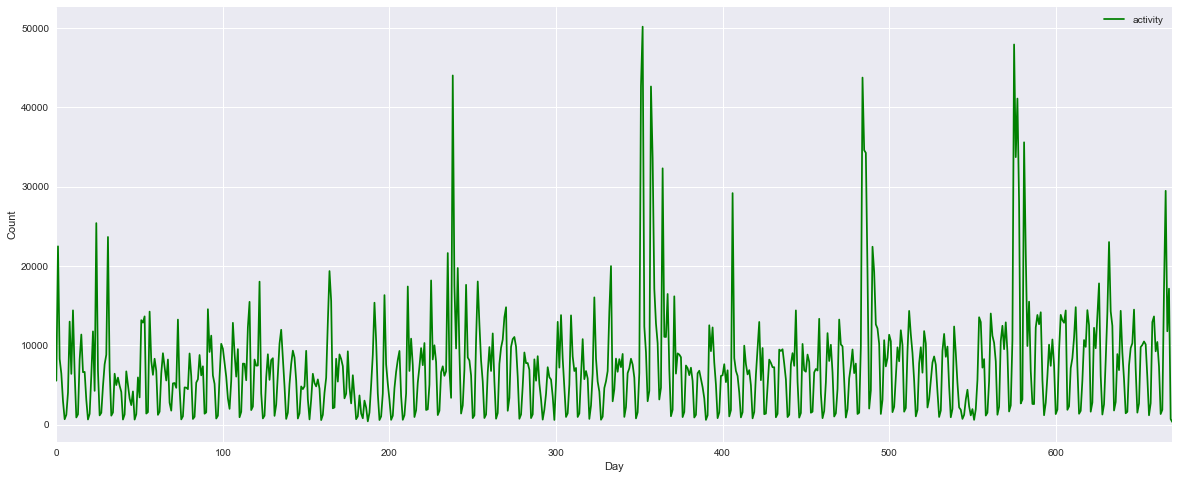

In [23]:
train.groupby('date')['activity'].count() 
dcd = train.groupby('date')['activity'].count().reset_index()
plt.figure()
with pd.plot_params.use('x_compat', True):
    dcd.plot(color='g', figsize=(20,8)).set_title('')
plt.xlabel('Day')
plt.ylabel('Count')

#Spikes indicate popular dates - maybe correspond with a marketing campaign or advertisement?

In [24]:
CustomerSupport_ = pid.groupby('date')['CustomerSupport'].sum().reset_index()
EmailOpen_ = pid.groupby('date')['EmailOpen'].sum().reset_index()
WebVisit_ = pid.groupby('date')['WebVisit'].sum().reset_index()
PageView_ = pid.groupby('date')['PageView'].sum().reset_index()
EmailClickthrough_ = pid.groupby('date')['EmailClickthrough'].sum().reset_index()
FormSubmit = pid.groupby('date')['FormSubmit'].sum().reset_index()
Purchase_ = pid.groupby('date')['Purchase'].sum().reset_index()

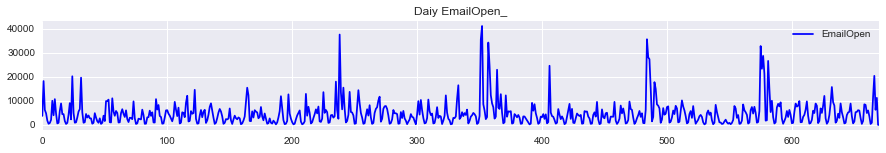

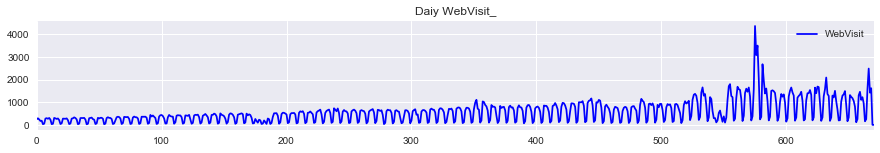

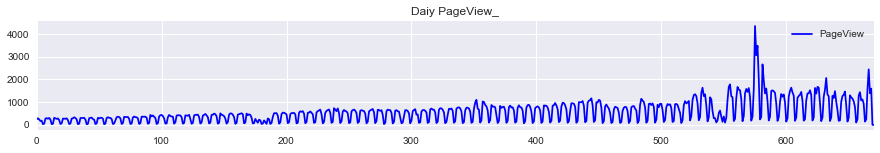

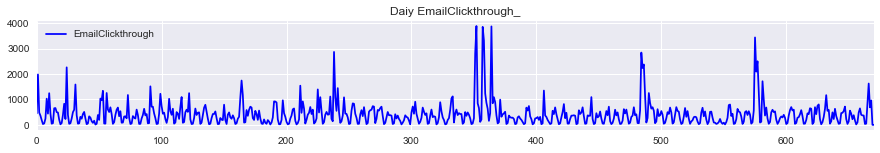

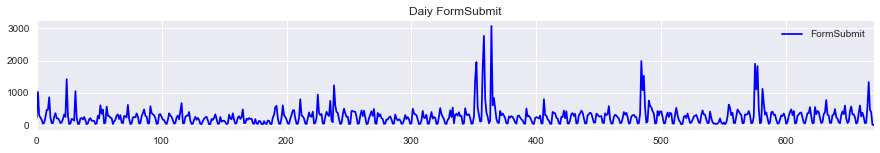

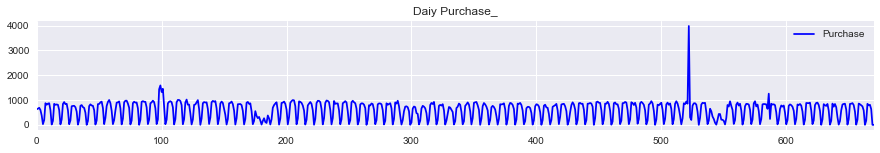

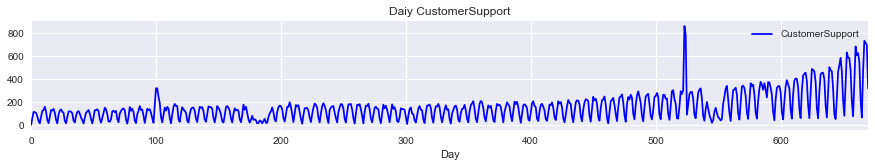

In [25]:
EmailOpen_ = EmailOpen_.groupby('date')['EmailOpen'].sum().reset_index()
CustomerSupport_ = CustomerSupport_.groupby(['date'])['CustomerSupport'].sum().reset_index()
WebVisit_ = WebVisit_.groupby('date')['WebVisit'].sum().reset_index()
PageView_ = PageView_.groupby('date')['PageView'].sum().reset_index()
EmailClickthrough_ = EmailClickthrough_.groupby('date')['EmailClickthrough'].sum().reset_index()
FormSubmit = FormSubmit.groupby('date')['FormSubmit'].sum().reset_index()
Purchase_ = Purchase_.groupby('date')['Purchase'].sum().reset_index()
plt.figure()
with pd.plot_params.use('x_compat', True):
    EmailOpen_.plot(color='b', figsize=(15,2)).set_title('Daiy EmailOpen_')
    WebVisit_.plot(color='b', figsize=(15,2)).set_title('Daiy WebVisit_')
    PageView_.plot(color='b', figsize=(15,2)).set_title('Daiy PageView_')
    EmailClickthrough_.plot(color='b', figsize=(15,2)).set_title('Daiy EmailClickthrough_')
    FormSubmit.plot(color='b', figsize=(15,2)).set_title('Daiy FormSubmit')
    Purchase_.plot(color='b', figsize=(15,2)).set_title('Daiy Purchase_')
    CustomerSupport_.plot(color='b', figsize=(15,2)).set_title('Daiy CustomerSupport')
plt.xlabel('Day')

In [26]:
#per user_id, total number of purchase events
purchasers_id=pd.crosstab(pid.user_id,columns=pid.Purchase,aggfunc=np.sum,values=pid.Purchase)

In [27]:
purchasers_id[1] = purchasers_id[1].fillna(0)

In [28]:
customers = purchasers_id[1]
#total number of customers
print('Total Customers:', customers.count())
#filtering out users with purchase = 0 
non_buyers = purchasers_id[1][purchasers_id[1]==0].count()
print('Users who never purchase:',non_buyers) #237577
print('Users with at least one Purchase:', customers[customers>=1].count())
print('% who do not make a purchase at all', 237577/341568) #69% 

Total Customers: 341568
Users who never purchase: 237577
Users with at least one Purchase: 103991
% who do not make a purchase at all 0.695548177815252


In [29]:
buyers = purchasers_id[1][purchasers_id[1]>=1]
buyers.describe() #buyers on average make 3-4 purchases

count    103991.000000
mean          3.798704
std           8.387857
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         352.000000
Name: 1.0, dtype: float64

In [30]:
buyers = buyers.reset_index()
buyers[1.0].value_counts().nlargest(5)/len(buyers)*100 
#52% of all buyers make 1 or 2 purchases only

1.0    47.730092
2.0    16.964930
3.0     9.561404
4.0     6.109183
5.0     4.033041
Name: 1.0, dtype: float64

In [31]:
#Feature Engineering
#Date - has many too many unique levels - throw out as it will add too many dimensions
#Ignore Customer Support

#New Features
#1) Weighing each user_id's activity compared to activity lifetime within dataset
#2) Tracking total number of Activity events per user_id
#3) Days between last activity and last date of dataset

In [32]:
len(pid.user_id.unique())

341568

In [33]:
activity_diff=train.pivot_table(aggfunc=[np.min,np.max],index='user_id',values='date')
activity_diff.reset_index(inplace=True)

In [34]:
activity_diff_test=test.pivot_table(aggfunc=[np.min,np.max],index='user_id',values='date')
activity_diff_test.reset_index(inplace=True)

In [35]:
activity_diff['d_diff'] = (train.date.max() - activity_diff['amax']).dt.days

In [36]:
activity_diff_test['d_diff'] = (test.date.max() - activity_diff_test['amax']).dt.days

In [37]:
train.date.max()

Timestamp('2015-05-02 00:00:00')

In [38]:
activity_days = activity_diff
activity_days = activity_days.drop(['amin','amax'], axis=1)
activity_days.columns

Index(['user_id', 'd_diff'], dtype='object')

In [39]:
activity_days_test = activity_diff_test
activity_days_test = activity_days_test.drop(['amin','amax'], axis=1)
activity_days_test.columns

Index(['user_id', 'd_diff'], dtype='object')

In [40]:
pid.shape == tid.shape

False

In [44]:
df = pid 
tst = df.groupby('user_id').sum().reset_index()
event_date=df.groupby('user_id')['date'].count().reset_index()
tst['Events'] = event_date['date']
tstt = tst[['CustomerSupport', 'EmailClickthrough','EmailOpen', 'FormSubmit', 'PageView',
     'Purchase', 'WebVisit']].div(tst.Events, axis=0)
tstt = tstt.rename(index=str, columns={"CustomerSupport": "CustomerSupport_perc", 
                                "EmailClickthrough": "EmailClickthrough_perc",
                                "EmailOpen": "EmailOpen_perc", 
                                "FormSubmit": "FormSubmit_perc",
                                "PageView": "PageView_perc", 
                                "Purchase": "Purchase_perc",
                                "WebVisit": "WebVisit_perc"})

dft = tid 
tstk = dft.groupby('user_id').sum().reset_index()
event_datet=dft.groupby('user_id')['date'].count().reset_index()
tstk['Events'] = event_datet['date']
tsttk = tstk[['EmailClickthrough','EmailOpen', 'FormSubmit', 'PageView',
     'WebVisit']].div(tstk.Events, axis=0)
tsttk = tsttk.rename(index=str, columns={ 
                                "EmailClickthrough": "EmailClickthrough_perc",
                                "EmailOpen": "EmailOpen_perc", 
                                "FormSubmit": "FormSubmit_perc",
                                "PageView": "PageView_perc",
                                "WebVisit": "WebVisit_perc"})

In [45]:
tst = tst.reset_index()
tstt = tstt.reset_index()
result = pd.merge(tst, tstt, left_index=True, right_index=True, how='outer')
del result['index_y']
del result['index_x']
result = pd.merge(result,activity_days, left_index=True, right_index=True, how='outer')
del result['user_id_y']

In [46]:
tstk = tstk.reset_index()
tsttk = tsttk.reset_index()
resultk = pd.merge(tstk, tsttk, left_index=True, right_index=True, how='outer')
del resultk['index_y']
del resultk['index_x']
resultk = pd.merge(resultk,activity_days_test, left_index=True, right_index=True, how='outer')
del resultk['user_id_y']

In [72]:
resultk.head(3)

,user_id_x,EmailClickthrough,EmailOpen,FormSubmit,PageView,WebVisit,Events,EmailClickthrough_perc,EmailOpen_perc,FormSubmit_perc,PageView_perc,WebVisit_perc,d_diff
0,0000ecf58c94668,0.0,5.0,0.0,0.0,0.0,5,0.0,1.0,0.0,0.0,0.0,2
1,000132f21724ee2,1.0,1.0,0.0,0.0,0.0,1,1.0,1.0,0.0,0.0,0.0,77
2,0001b315b991cf0,0.0,3.0,0.0,0.0,0.0,3,0.0,1.0,0.0,0.0,0.0,31


In [47]:
result['target']=result['Purchase']>0
result['target']=result['target'].astype('int64')

In [49]:
result.shape

(341568, 18)

In [50]:
rez = result[['EmailClickthrough_perc', 'EmailOpen_perc','FormSubmit_perc', 
        'PageView_perc', 'WebVisit_perc']]

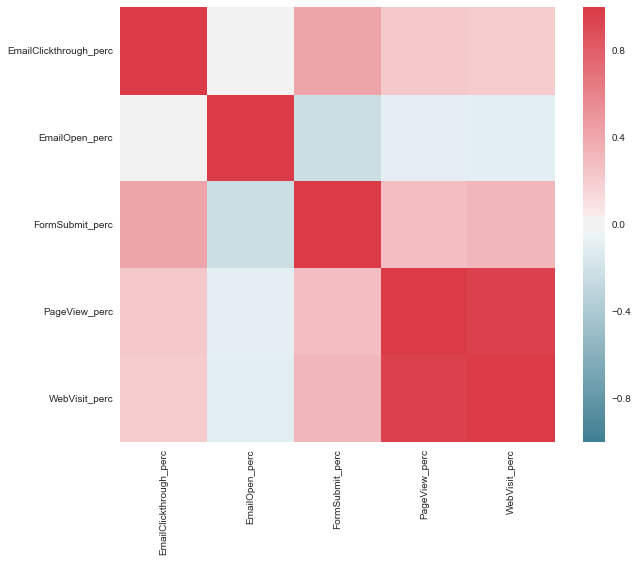

In [51]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = rez.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [53]:
#Modeling

In [54]:
# features=['EmailOpen','EmailClickthrough','PageView','WebVisit','Events','FormSubmit',
#           'EmailClickthrough_perc', 'EmailOpen_perc','FormSubmit_perc', 
#           'PageView_perc', 'WebVisit_perc', 'd_diff']

features=['EmailClickthrough_perc', 'Events','EmailOpen_perc','FormSubmit_perc', 'PageView_perc', 'WebVisit_perc', 'd_diff']

#leaving out user_id

X=result[features]
Y=result['target']

In [55]:
len(features)

7

In [56]:
#Model Choice - Random Forest Pros: Non-parametric, so we don't have to worry about outliers or whether the data is linearly separable. Does not suffer multicollinearity. OOB process reduces overfitting. Random forests tend to beat out 
#logistic regression in terms of accuracy which we can test.
#Split the data set into 2 parts: training set, 
#test set(random_state=0, and test_size=1/3).

In [57]:
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

print('Train data set ratio: ', sum(Y_train)/float(X_train['d_diff'].count()))
print('Test data set ratio:  ', sum(Y_test)/float(X_test['d_diff'].count()))

/Users/wandawang/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Train data set ratio:  0.30426981518
Test data set ratio:   0.304876501644


In [58]:
#Random Forest. Fit a random forest on the training set. 
#Report the training error and test error. Use the function grid_search.GridSearchCV to find the best parameters. What's the best parameters? What's the best score? What's the training error and test error of the best model. 
#The possible combination of the parameters may be:
#Feature importance plot

In [59]:
from sklearn import ensemble
rf_model = ensemble.RandomForestClassifier()
rf_model.fit(X_train, Y_train)
print("Random forest training error: ", rf_model.score(X_train, Y_train))
print("Random forest test error: ", rf_model.score(X_test, Y_test))

Random forest training error:  0.998958581664
Random forest test error:  0.986318080237


In [60]:
#With more time, would've optimized parameters using GridSearchCV

In [81]:
from sklearn import ensemble
randomForest = ensemble.RandomForestClassifier(n_jobs = -1, oob_score=True) #adding oob
import sklearn.grid_search as gs 
grid_para_forest = [{"n_estimators": [10], "criterion": ["gini"], 
                     'max_depth': [3], "min_samples_leaf": [3]}]

grid_search_forest = gs.GridSearchCV(randomForest, grid_para_forest, \
          cv=5, scoring='accuracy').fit(X_train, Y_train)

In [62]:
forest_final = grid_search_forest.best_estimator_
feature_imprtance = list(zip(X_train.columns, forest_final.feature_importances_))
dtype = [('feature', 'S30'), ('importance', 'float')]
feature_imprtances = np.array(feature_imprtance, dtype = dtype)
feature_sort = np.sort(feature_imprtances, order='importance')[::-1]
feature_sort[0:15]

array([(b'EmailOpen_perc', 0.38376091567277176),
       (b'Events', 0.27955442520902096),
       (b'EmailClickthrough_perc', 0.2056160897748207),
       (b'd_diff', 0.05196152429056815),
       (b'FormSubmit_perc', 0.046604055380888264),
       (b'WebVisit_perc', 0.01690449165134007),
       (b'PageView_perc', 0.015598498020590138)], 
      dtype=[('feature', 'S30'), ('importance', '<f8')])

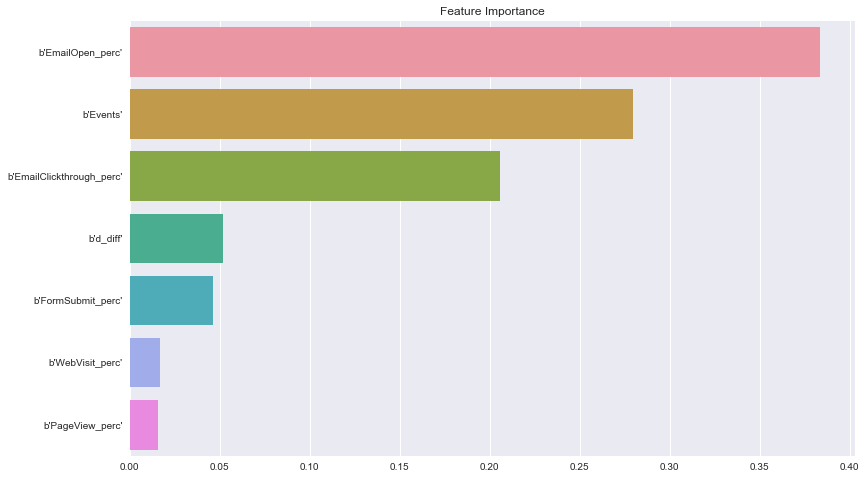

In [63]:
feature_sort_columns = [i for (i, j) in feature_sort[0:30]] 
plt.figure(figsize=(13, 8))
plt.title("Feature Importance")
importances = [j for (i, j) in feature_sort[0:30]] 
sns.barplot(y=feature_sort_columns, x=importances, ci=None)

In [92]:
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier(max_features=7, n_estimators=100, 
                                 learning_rate=0.05, random_state= 2015)
gbm.fit(X_train, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=7, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=2015,
              subsample=1.0, verbose=0, warm_start=False)

In [93]:
import sklearn.metrics
print(sklearn.metrics.roc_auc_score(Y_train, gbm.predict_proba(X_train)[:,1]))
print(sklearn.metrics.roc_auc_score(Y_test, gbm.predict_proba(X_test)[:,1]))

0.998641987745
0.998592801185


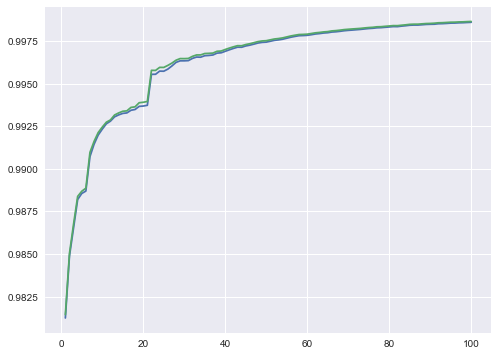

In [94]:
def plot_gbt_learning(gbt):
    test_score = np.empty(len(gbt.estimators_))
    train_score = np.empty(len(gbt.estimators_))
    for i, pred in enumerate(gbt.staged_predict_proba(X_test)):
         test_score[i] = sklearn.metrics.roc_auc_score(Y_test, pred[:,1])
    for i, pred in enumerate(gbt.staged_predict_proba(X_train)):
         train_score[i] = sklearn.metrics.roc_auc_score(Y_train, pred[:,1])
    plt.figure(figsize=(8,6))
    plt.plot(np.arange(gbt.n_estimators) + 1, test_score, label='Test') 
    plt.plot(np.arange(gbt.n_estimators) + 1, train_score, label='Train')
plot_gbt_learning(gbm)

In [ ]:
#The above plot shows that an AUC score of 0.9975 is reached within 50 estimators for both training(red) and test sets(blue).

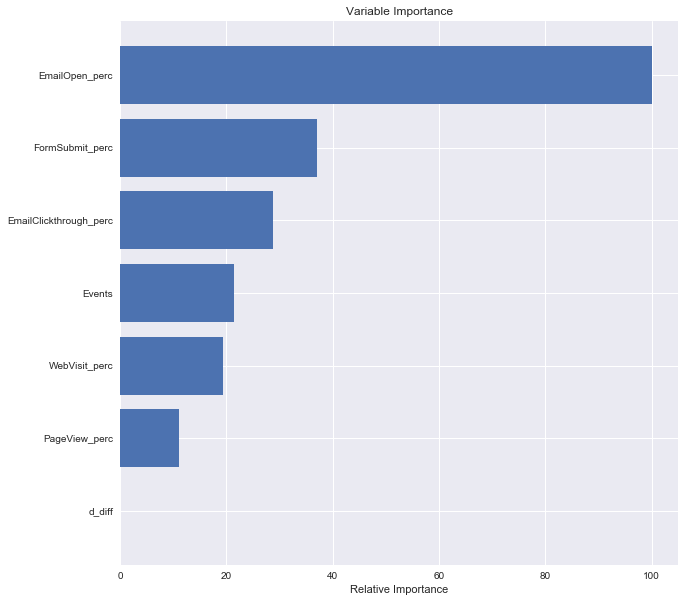

In [95]:
feature_importance = gbm.feature_importances_ 
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10, 10))
#plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[[sorted_idx]])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
#Q1: In both the Random Forest and Gradient Boosting Model, 
#EmailOpen was shown to be the most important feature

In [ ]:
#Q2 1000 user_ids:

In [119]:
features=['EmailClickthrough_perc', 'Events','EmailOpen_perc','FormSubmit_perc', 'PageView_perc', 'WebVisit_perc', 'd_diff']
test_f = resultk[features]
predict_test=forest_final.predict(test_f)
prob_test = forest_final.predict_proba(test)
variables =['user_id_x','EmailClickthrough_perc', 'Events','EmailOpen_perc','FormSubmit_perc', 'PageView_perc', 'WebVisit_perc', 'd_diff']
testdata=resultk[variables]
pred_forest=pd.DataFrame(data=[predict_testing,probs_testing[:,0],probs_testing[:,1]]).transpose()
pred_forest.rename(columns={0: 'Prediction', 1: 'C_0',2:'C_1'}, inplace=True)
pred_forest['user_id_x']=testdata['user_id_x']

In [120]:
preds=pred_forest[pred_forest['Prediction']==1.0].sort_values('C_1',ascending=False)
forest_p=preds[['user_id_x','C_1','C_0']][0:1000]
forest_p.to_csv('users.csv',index=False)